# Significance formulae

Here we discuss the issues with the significance of the smoothed map

In [1]:
from __future__ import division
import numpy as np
import healpy as hp  # need version 1.12.5 or higher
import matplotlib.pyplot as mp
from scipy.integrate import quad
from scipy.optimize import fsolve, curve_fit
from ipywidgets import FloatProgress
from IPython.display import display
from tools import *

Read the exposure map, made by Maria. The exposure map is made as following:
1. pick a random event, take the in-detector coordinates of the particle
2. pick another random event, take the orbit coordinates of DAMPE
3. Using these data put this mixed-event particle on the sky
4. Repeat for all the events. Then you get a map
5. Repeat steps 1-4 multiple times (100 is OK)
6. Take an average of the resulting maps

Such a map is also called the isotropy map, since this is what we would see if there is no anisotropy on the sky. <br>
Here it is the average of 1000 isotropy maps, produced using the data for all the particles from 100 to 500 GeV

__NOTE__ that the event-shuffling method, described above, is not valid. See rate-based_MC.ipynb for more details.

In [2]:
iso_map = np.load('iso_map.npy')
nside = hp.npix2nside(len(iso_map))

We'll work in the __equatorial coordinate system__. The exposure map is then symetric on the Right Ascension (RA or $\alpha$, the horisontal axis on the plot, measures in hours from 0 to 24) and we can study the dependencies on the declination (dec or $\delta$, the vertical axis, measures from $-90^\circ$ on the South pole to $+90^\circ$ on the North pole) <br>

BTW, rotation works with nside at least 32

In [3]:
r = hp.rotator.Rotator(coord='GC')
# Optional parameter power=-2 allows to keep the integral of the map unchanged
iso_map = hp.ud_grade(iso_map, 32, power=-2)
nside = 32
iso_map = r.rotate_map_alms(iso_map)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


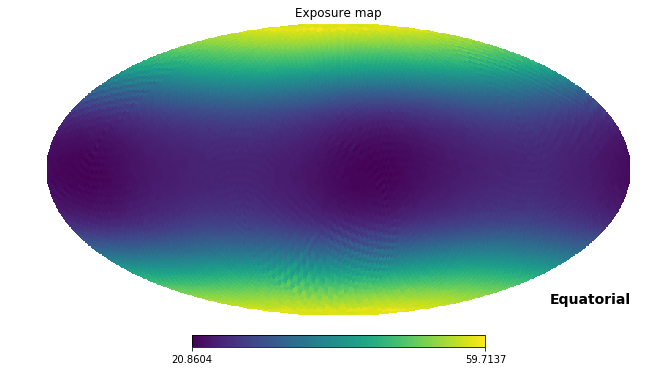

In [4]:
hp.mollview(iso_map, coord='C', title='Exposure map')
mp.show()

## Create an anisotropy map with no noise
Feel free to play with the input to this function, changing the direction and the strength of the dipole

0.010000000023006274


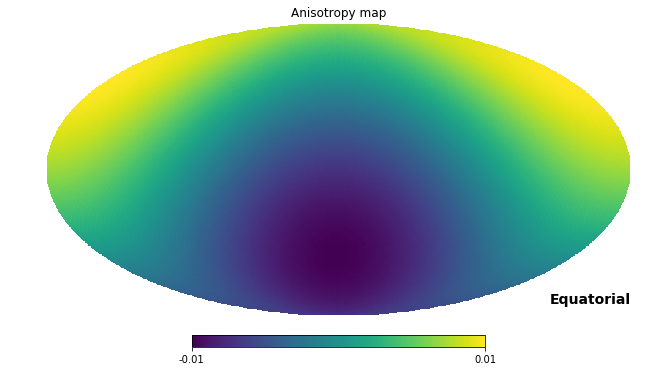

In [5]:
ani_map = create_dipole_map(nside, 1e-2, lonlat=(180, 45))
hp.mollview(ani_map, coord='C', title='Anisotropy map')
print(get_dipole_ampl(ani_map))

### Create an observation map (the map you realy observe) <br>
The anisotropy map is given as $\frac{\text{observation map}}{\text{exposure map}} - 1$ <br>
So the observation map is $(\text{anisotropy map} + 1) \times \text{exposure map}$ <br>

In [6]:
obs_map = get_obs_map(ani_map, iso_map)

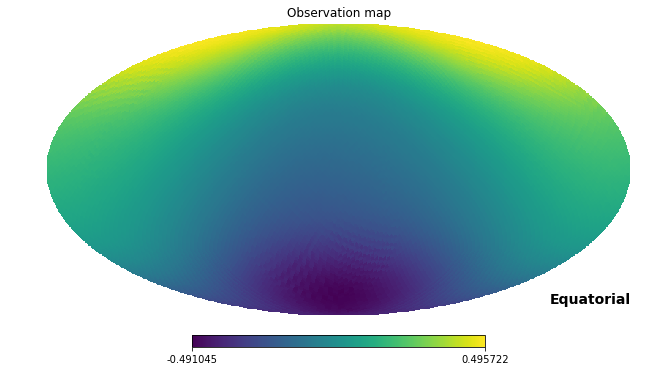

In [7]:
hp.mollview(obs_map, coord='C', title='Observation map')
mp.show()

### Let's take a look on the real observation map too

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


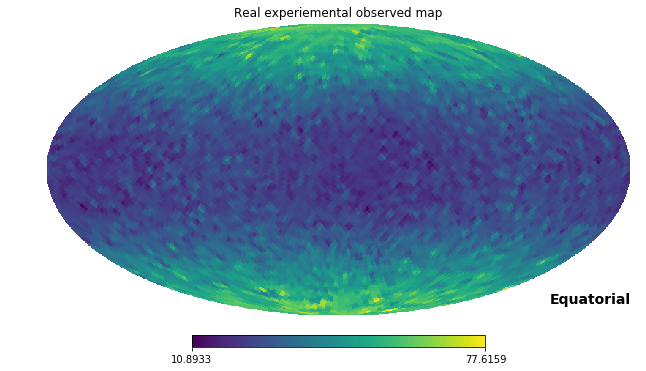

In [8]:
obs_map_real = np.load('map_realdata_ntuple_xin_100_500_GeV.npy')
obs_map_real = hp.ud_grade(obs_map_real, nside, power=-2)
obs_map_real = r.rotate_map_alms(obs_map_real)
hp.mollview(obs_map_real, coord='C', title='Real experiemental observed map')
mp.show()

### What is the level of noise on the real observed map?

Each pixel is a sum of N observations of the flux, where N is the value in this pixel on the exposure map <br>

Hence, to get the flux you just divide this value by the number of the observations. Here is how it looks like:

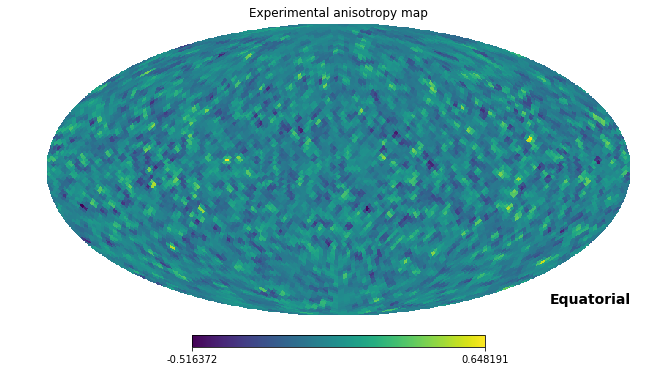

In [9]:
hp.mollview(obs_map_real / iso_map - 1, coord='C', title='Experimental anisotropy map')
mp.show()

Let's assume we have a constant flux. Then the measured flux can deviate from it's true value by $\frac{1}{\sqrt{N}}$.

The blue points on the plot below should be within the orange line 1-sigma-limits

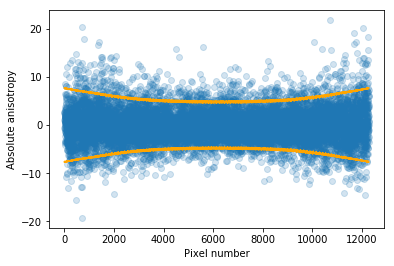

In [10]:
temp1 = obs_map_real - iso_map
temp2 = np.sqrt(iso_map)
mp.plot(temp1, 'o', alpha=0.2)
mp.plot(temp2, c='orange')
mp.plot(-temp2, c='orange')
mp.xlabel('Pixel number')
mp.ylabel('Absolute anisotropy')
mp.show()

### Let's try to simulate the noisy map, which would look like the real observed sky

In [11]:
noise_sky = create_noise_map(iso_map)

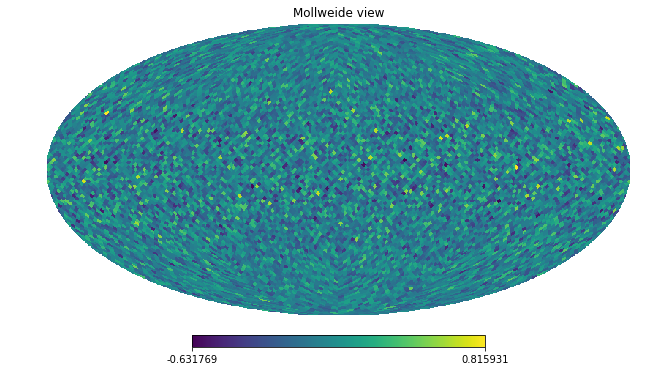

In [12]:
hp.mollview(noise_sky)
mp.show()

Let's add some anisotropy

In [13]:
model_map = noise_sky + ani_map  # modelled anisotropy map

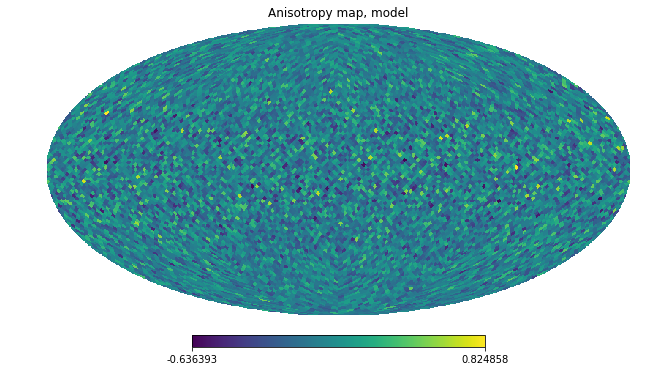

In [14]:
hp.mollview(model_map, title='Anisotropy map, model')
mp.show()

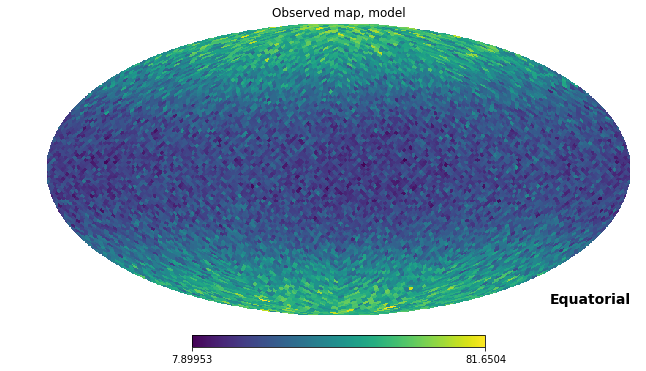

In [15]:
obs_map_model = get_obs_map(iso_map, model_map) # What you would observe
hp.mollview(obs_map_model, coord='C', title='Observed map, model')
mp.show()

### Top-hat integration <br>

In order to show the anisotropies more clear they usually use the top-hat integration, like in the Fermi work (1008.5119).

In [16]:
integrated_90_noiseless, npix_90 = tophat_smoothing(ani_map, 90)

FloatProgress(value=0.0, max=12288.0)

In [17]:
integrated_90, npix_90 = tophat_smoothing(model_map, 90)

FloatProgress(value=0.0, max=12288.0)

In [18]:
integrated_20, npix_20 = tophat_smoothing(model_map, 20)

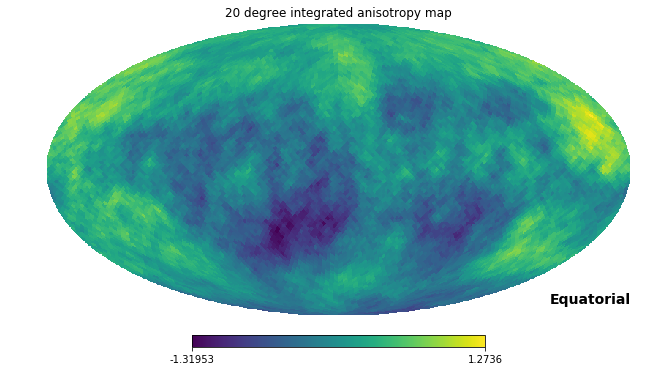

In [19]:
hp.mollview(integrated_20, coord='C', title='20 degree integrated anisotropy map')

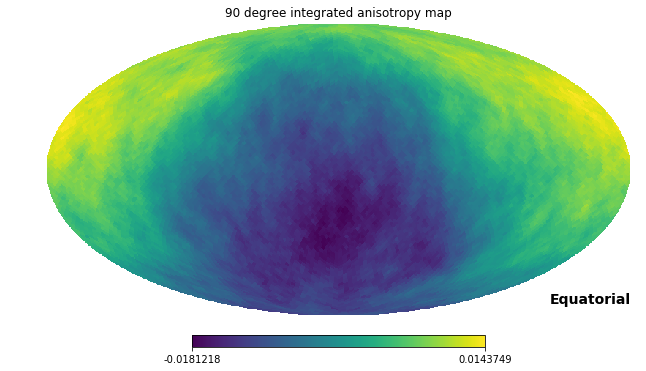

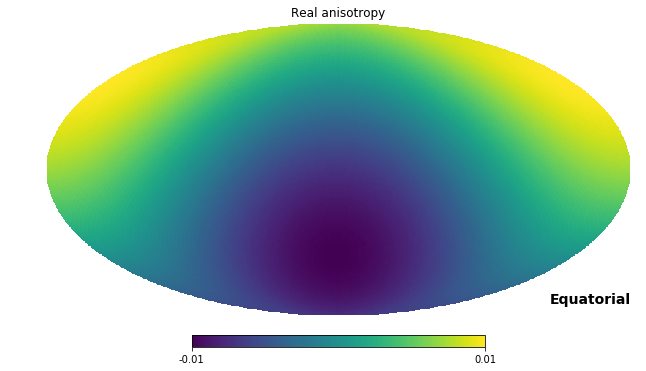

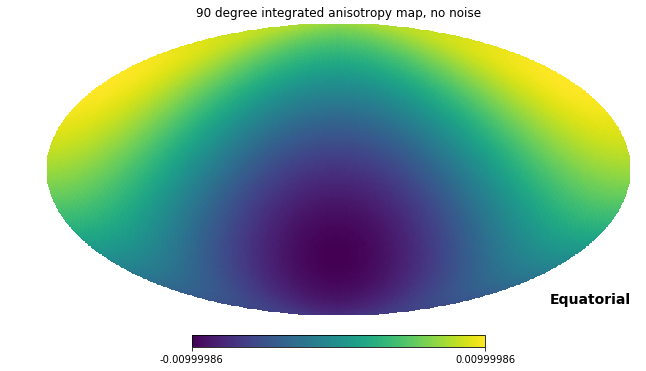

In [20]:
hp.mollview(integrated_90, coord='C', title='90 degree integrated anisotropy map')
hp.mollview(ani_map, coord='C', title='Real anisotropy')
hp.mollview(integrated_90_noiseless, coord='C', title='90 degree integrated anisotropy map, no noise')
mp.show()

In [21]:
theta_phi_rec = hp.vec2ang(hp.fit_dipole(integrated_90)[1], lonlat=True)
theta_phi_inp = hp.vec2ang(hp.fit_dipole(ani_map)[1], lonlat=True)
dist = np.degrees(hp.rotator.angdist([theta_phi_inp[0][0], theta_phi_inp[1][0]],
                                     [theta_phi_rec[0][0], theta_phi_rec[1][0]],
                                     lonlat=True))[0]
print 'Distance between the real dipole direction and the reconstructed one is {:.2f} degrees'.format(dist)

Distance between the real dipole direction and the reconstructed one is 10.33 degrees


## Significance
The significance is defined as $S \approx \sqrt{\frac{N_{on}}{1 + \alpha}} \delta I$, see arXiv:1612.01873 <br>
where $N_{on}$ is the number of events "on source",<br>
$\alpha$ is the relative exposure, defined as the ratio of exposures on source and off source <br>
$\delta I$ is the anisotropy map. <br>

Since here we are interested in the whole sky and there is no particular source we are looking for, the $N_{on}$ is just the observed map and $\alpha = 1$ <br>

Note that the significance grows as the square root of the number of the registered events. It makes sence, doesn't it? <br>

HAWC also uses the same formula, see arXiv:1805.01847 <br>

Here is another formula, from a highly cited paper of Li & Ma, 1983: <br>

$S = \pm \sqrt{2} \left ( N_{on} \ln{\frac{1 + \alpha}{\alpha}\frac{N_{on}}{N_{on} + N_{off}}} + N_{off} \ln{(1 + \alpha)\frac{N_{off}}{N_{on} + N_{off}}} \right ) ^{1/2}$

This formula was used in the PAMELA paper arXiv:1509.06249, where they assume that the $N_{on}$ is the observation map, $N_{off}$ is the isotropy map (exposure), and $\alpha =1$

In [22]:
def get_sig_map_HAWC(obs_map, ani_map):
    return np.sqrt(obs_map / 2) * ani_map

In [23]:
def get_sig_map_PAMELA(obs_map, iso_map):
    first = obs_map * np.log(2 * obs_map / (obs_map + iso_map))
    second = iso_map * np.log(2 * iso_map / (obs_map + iso_map))
    sign = np.sign(get_ani_map(obs_map, iso_map))
    return sign * np.sqrt(2 * (first + second))

In [24]:
sig_map_HAWC_90 = get_sig_map_HAWC(obs_map_model, integrated_90)
sig_map_HAWC_20 = get_sig_map_HAWC(obs_map_model, integrated_20)
sig_map_HAWC = get_sig_map_HAWC(obs_map_model, model_map)
# sig_map_PAMELA = get_sig_map_PAMELA(obs_map_model, iso_map)

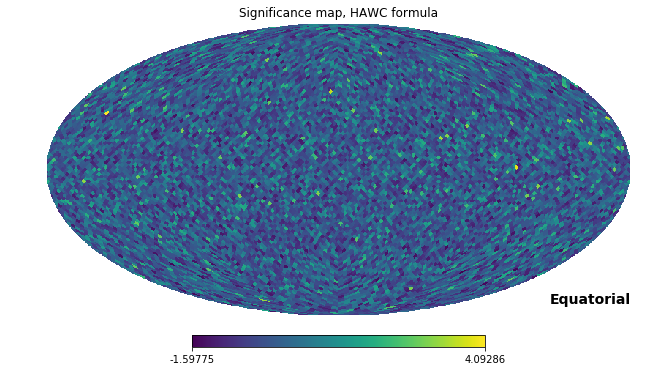

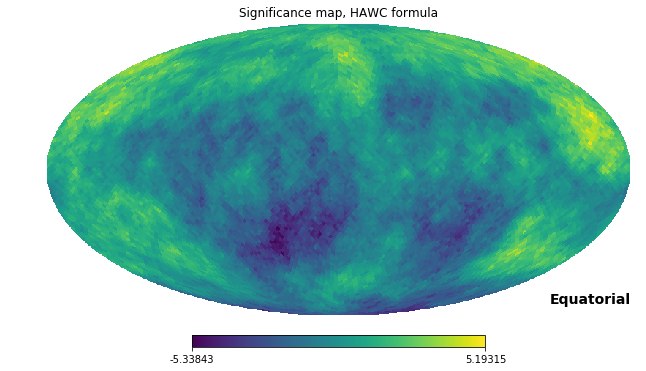

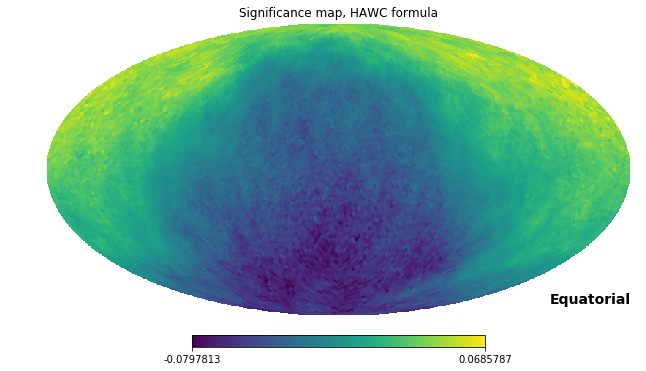

In [25]:
hp.mollview(sig_map_HAWC, coord='C', title='Significance map, HAWC formula')
hp.mollview(sig_map_HAWC_20, coord='C', title='Significance map, HAWC formula')
hp.mollview(sig_map_HAWC_90, coord='C', title='Significance map, HAWC formula')
# hp.mollview(sig_map_PAMELA, coord='C', title='Significance map, PAMELA formula')
# hp.mollview(sig_map_HAWC - sig_map_PAMELA, coord='C', title='Difference in significance maps')
mp.show()

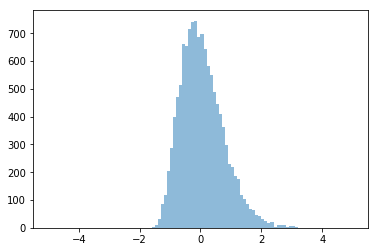

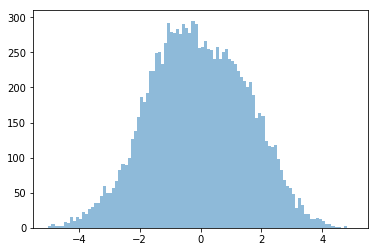

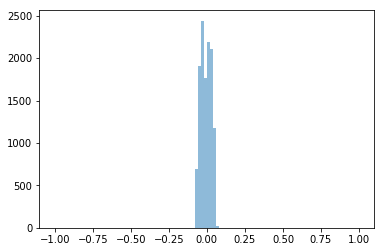

In [31]:
mp.hist(sig_map_HAWC, 100, range=(-5, 5), alpha=0.5)
mp.show()
mp.hist(sig_map_HAWC_20, 100, range=(-5, 5), alpha=0.5)
mp.show()
mp.hist(sig_map_HAWC_90, 100, range=(-1, 1), alpha=0.5)
mp.show()

The problem is evident: you use the appropiate formula to the smoothed map, where the anisotropy is evident. And you get almost zero significance!

### Ideas about the significance of the integrated map

Imagine a very stupid model of the sky:

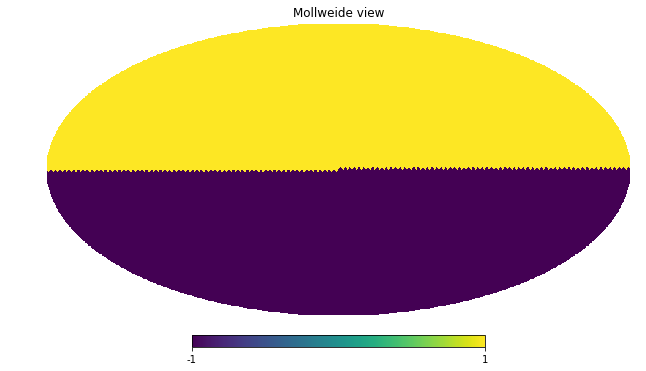

In [34]:
nside = 32
npix = hp.nside2npix(nside)
stupid_sky = np.ones(npix)
stupid_sky[int(npix / 2):] = -1.
hp.mollview(stupid_sky)

And let's add there a very stong noise:

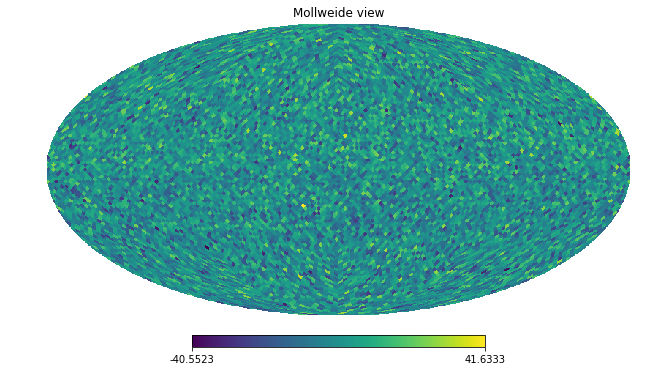

In [35]:
strong_noise = np.random.normal(0., 10., npix)
stupid_sky += strong_noise
hp.mollview(stupid_sky)

So now you can't see the anisotropies, even though in fact they are there

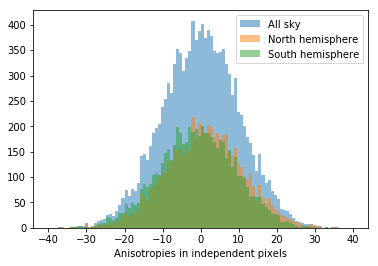

In [36]:
mp.hist(stupid_sky, 100, range=(-40., 40.), alpha=0.5, label='All sky')
mp.hist(stupid_sky[:int(npix / 2)], 100, range=(-40., 40.), alpha=0.5, label='North hemisphere')
mp.hist(stupid_sky[int(npix / 2):], 100, range=(-40., 40.), alpha=0.5, label='South hemisphere')
mp.legend()
mp.xlabel('Anisotropies in independent pixels')
mp.show()

Now if we'll take an __average__ in each pixel over 90 degrees cup we get this map:

FloatProgress(value=0.0, max=12288.0)

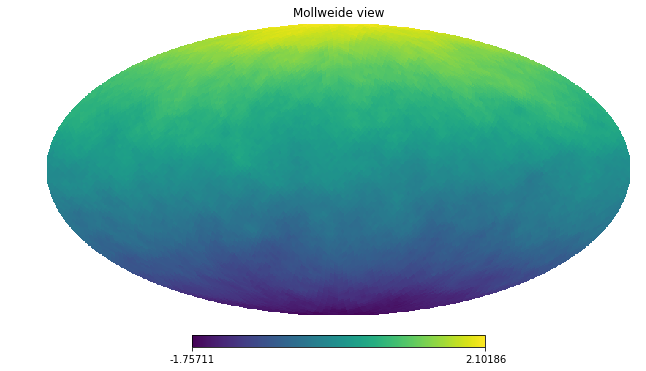

In [37]:
integrated_stupid_map, pix_num = tophat_smoothing(stupid_sky, 90)
hp.mollview(integrated_stupid_map)

BTW, note that this smoothed map goes from -2 to 2 (while the noiseless map was from -1 to 1). You should understand that:
- First: instead of integrating the map in tophat windows, I take the average
- Second: I normalize to the number of pixels under the circle mask.

You can try to changing it and see the effect you'd have on a no-noise dipole map and on the reconstructed dipole amplitude.

Let's take the north pole pixel (index 0) and the south pole pixel (index npix-1). They represent the average over the north and south hemispheres respectively. The __error__ of this average is equal to $\sigma \over \sqrt{N_{pix}}$, where $\sigma$ is the intrinsic noise standard deviation and $N_{pix}$ is the number of pixels over which you make the integration (don't confuse it with npix. For $90^\circ$ integration $N_{pix} = $0.5npix.)

We know how to quantify the difference of two samples with slightly different means. If we have two samples like this:

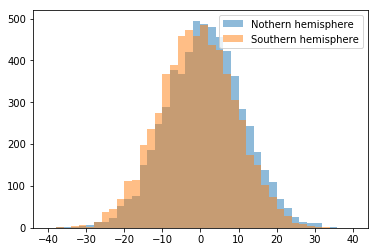

In [38]:
s1 = stupid_sky[:int(npix / 2)]
s2 = stupid_sky[int(npix / 2):]
mp.hist(s1, 40, range=(-40, 40), alpha=0.5, label='Nothern hemisphere')
mp.hist(s2, 40, range=(-40, 40), alpha=0.5, label='Southern hemisphere')
mp.legend()
mp.show()

Then __significance of the hypothesis__ that these two samples are different is equal to

${|\mu_1 - \mu_2|}\over{\sqrt{{{\sigma_1^2}\over{N_1}} + {{\sigma_2^2}\over{N_2}}}}$

In [39]:
print((s2.mean() - s1.mean()) / np.sqrt(s1.std()**2 / len(s1) + s2.std()**2 / len(s2)))

-10.708630865801677


Similarly, the significance of the hypothesis that the north and south pixels are different is equal to

${{|\mu_1 - \mu_2|}\over{\sqrt{{{1}\over{N_{pix}}} + {{1}\over{N_{pix}}}}}} = \sqrt{N_{pix}}{{|\mu_1 - \mu_2|}}$

We need a slightly different thing -- the significance of the hypothesis that these pixels are different from the _isotropy_:

$\sqrt{N_{pix}}{(\mu - 0)} = \sqrt{N_{pix}}{{\mu}}$

Now it looks almost like the HAWC significance formula. But in HAWC formula they take into account the

- Number of observations in each pixel:

$\sqrt{N_{pix} N_{obs}}{\mu}$

- And the relative exposition:

$\sqrt{{N_{pix} N_{obs}}\over{1 + \alpha}}{\mu}$

Or

$S = \sqrt{{N_{pix} N_{obs}}\over{1 + \alpha}}{\delta I}$

In [40]:
def get_sig_map_MY(obs_map, ani_map, npix_map):
    return np.sqrt(npix_map * obs_map / 2) * ani_map

In [41]:
# I modeled the noise with some given "strong" sigma.
# So here I should divide by it

sig_map_stupid = get_sig_map_MY(np.ones(hp.nside2npix(nside)),
                                integrated_stupid_map, 
                                pix_num) / strong_noise.std()

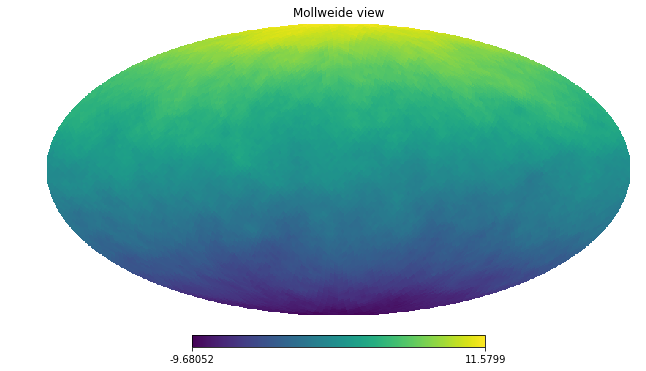

In [42]:
hp.mollview(sig_map_stupid)

Let's try to change the amplitude of the stupid dipole to get the significance 1

In [50]:
stupid_sky = np.ones(npix) * 0.2
stupid_sky[int(npix / 2):] *= -1
stupid_sky += strong_noise

FloatProgress(value=0.0, max=12288.0)

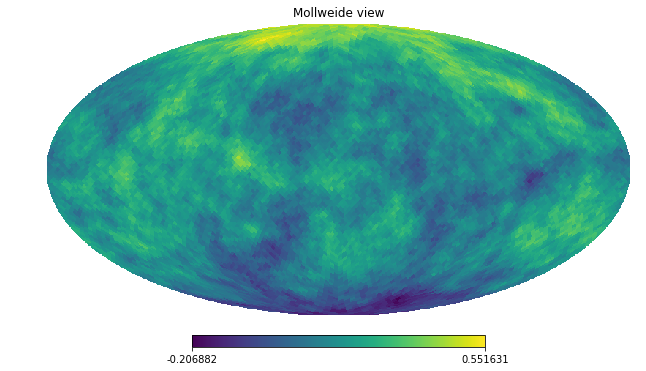

In [51]:
integrated_stupid_map, pix_num = tophat_smoothing(stupid_sky, 90)
hp.mollview(integrated_stupid_map)

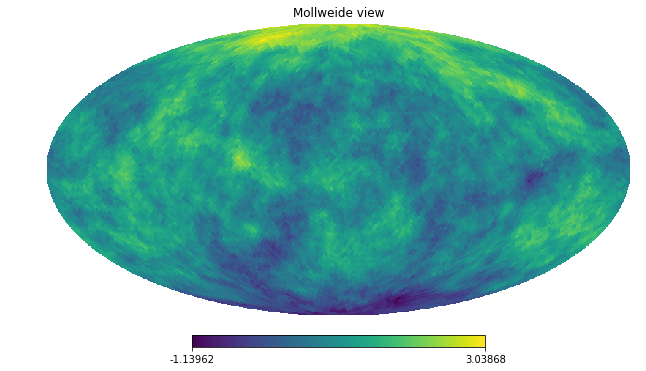

In [52]:
sig_map_stupid = get_sig_map_MY(np.ones(hp.nside2npix(nside)),
                                integrated_stupid_map, 
                                pix_num) / stupid_sky.std()
hp.mollview(sig_map_stupid)